# Results Analysis #
--------------------

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino'], 'size': 11})
CSV_PATH = "./data/P4_N4096000_STRONG_LOCAL/"
FW_PATH = "./data/framework_comparison/"
POL_PATH = "./data/policy_comparison/"
GLOB_PATH = "./data/global_queue/"

In [120]:
files = os.listdir(CSV_PATH)
forks = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(CSV_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,77.3672,0,CREATE,0.000000,0.000
0,77.4164,1,CREATE,0.000000,1.000
0,77.4516,2,CREATE,0.000000,2.000
0,77.4806,3,CREATE,0.000000,3.000
1,77.5937,0,SC_BGN,0.000000,NaN
2,77.5991,0,CHI_NO,3.000000,0.455
3,77.6063,0,SC_GLB,NaN,NaN
1,77.6792,3,RT_BGN,NaN,NaN
1,77.6799,1,RT_BGN,NaN,NaN
2,77.6862,3,RT_GLB,0.000000,NaN


,Time (ms),ID,Code,info1,info2
0,77.5074,0,CREATE,1.0,0.0
0,77.5317,1,CREATE,1.0,1.0
0,77.5619,2,CREATE,1.0,2.0
0,77.5890,3,CREATE,1.0,3.0
1,77.6920,3,SC_BGN,0.0,NaN
2,77.6960,3,SC_LOC,NaN,NaN
3,77.7224,3,SC_BGN,-1.0,NaN
4,77.7267,3,SC_LOC,NaN,NaN
5,77.7426,3,SC_BGN,-2.0,NaN
6,77.7459,3,SC_LOC,NaN,NaN


## Queue Dimensions ##

In [3]:
n_ws = len(forks.ID.unique())
loc_hs = np.zeros((n_ws, len(forks)))
glob_h = np.zeros(len(forks))

last_l = np.zeros(n_ws)
last_g = 0

for i, (t, wid, code, i1, i2) in enumerate(forks.itertuples(index=False, name=None)):
    if code == "SC_LOC":
        last_l[wid] += 1
    elif code == "RT_LOC":
        last_l[wid] -= 1
    elif code == "SC_GLB":
        last_g += 1
    elif code == "RT_GLB":
        last_g -= 1
    
    loc_hs[:, i] = last_l
    glob_h[i] = last_g

In [4]:
dfs = []

for i in range(n_ws):
    local = forks[['Time (ms)']].copy()
    local['Size'] = loc_hs[i, :]
    local['Queue'] = "$W_{}$".format(i)
    dfs.append(local)

glob = forks[['Time (ms)']].copy()
glob['Size'] = glob_h
glob['Queue'] = "Global"
dfs.append(glob)

queues = pd.concat(dfs).sort_values('Time (ms)')
queues[['Size', 'Queue']].groupby('Queue').describe()

Size                                             
          count      mean       std  min  25%  50%  75%  max
Queue                                                       
$W_0$   12300.0  3.791382  1.698770  0.0  3.0  4.0  5.0  9.0
$W_1$   12300.0  3.571707  1.755105  0.0  2.0  4.0  5.0  9.0
$W_2$   12300.0  3.792520  1.499234  0.0  3.0  4.0  5.0  8.0
$W_3$   12300.0  3.252927  1.531896  0.0  2.0  3.0  4.0  8.0
Global  12300.0  2.910732  1.642739  0.0  2.0  3.0  5.0  6.0

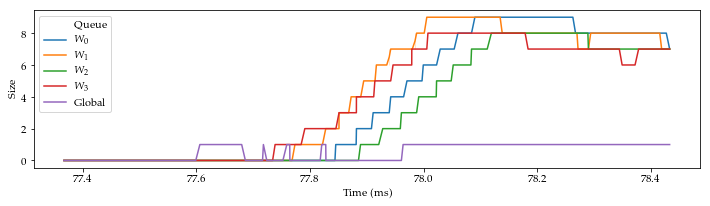

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(data=queues[:800], x='Time (ms)', y='Size', hue='Queue', hue_order=sorted(queues.Queue.unique()))
ax.legend()

plt.tight_layout()
plt.savefig("../report/figures/startup.pdf", format='pdf', bbox_inches='tight')
plt.show()

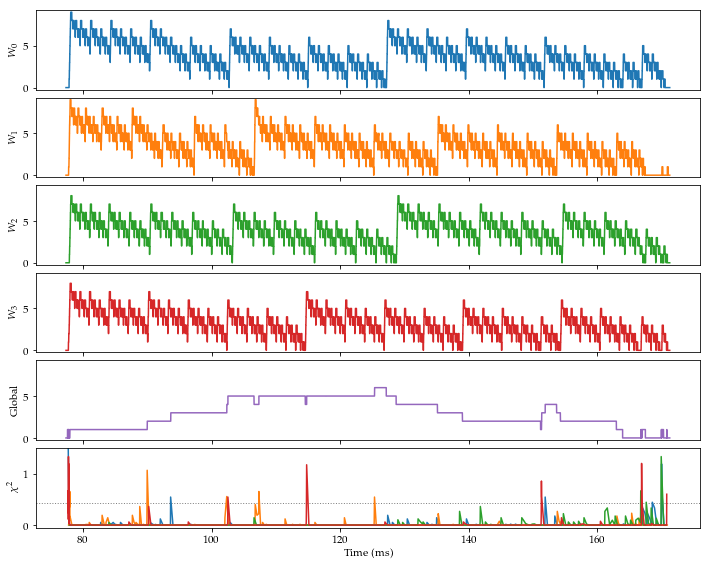

In [55]:
fig, axes = plt.subplots(n_ws + 2, 1, figsize=(10, 8), sharex=True)
max_size = queues['Size'].max()

for i, q in enumerate(sorted(queues.Queue.unique())):
    sns.lineplot(data=queues[queues.Queue == q], x='Time (ms)', y='Size', color='C{}'.format(i), ax=axes[i])
    axes[i].set_ylim((-0.25, max_size + 0.25))
    axes[i].set_ylabel(q)

chis = forks[forks.Code.apply(lambda c: c.startswith('CHI_'))].copy()
chis['info1'] = chis.apply(lambda r: 0. if r['Code'] == 'CHI_SK' else r['info1'], axis=1)

axes[n_ws+1].axhline(0.433, linestyle=':', linewidth=1., c='gray')

for i in range(n_ws):
    chis[chis.ID == i].plot(x='Time (ms)', y='info1', color='C{}'.format(i), ax=axes[n_ws+1])
    
axes[n_ws+1].set_ylabel(r'$\chi^2$')
axes[n_ws+1].get_legend().remove()
axes[n_ws+1].set_ylim((-0.05, 1.5))
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("../report/figures/queues.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Waiting Time ##
### 4 Workers ###

In [121]:
n_ws = len(forks.ID.unique())
rt_wait = np.zeros((n_ws, len(forks)), dtype=bool)
sc_wait = np.zeros((n_ws, len(forks)), dtype=bool)

last_rt = np.zeros(n_ws, dtype=bool)
last_sc = np.zeros(n_ws, dtype=bool)

for i, (t, wid, code, i1, i2) in reversed(list(enumerate(forks.itertuples(index=False, name=None)))):
    if code == "SC_GLB":
        last_sc[wid] = True
    elif code == "RT_GLB":
        last_rt[wid] = True
    elif code == "SC_BGN":
        last_sc[wid] = False
    elif code == "RT_BGN":
        last_rt[wid] = False
    
    rt_wait[:, i] = last_rt
    sc_wait[:, i] = last_sc
    
rt_wait = np.logical_or(rt_wait, np.roll(rt_wait, 1, axis=1))
sc_wait = np.logical_or(sc_wait, np.roll(sc_wait, 1, axis=1))

In [122]:
dfs = []

for i in range(n_ws):
    rt = forks[['Time (ms)']].copy()
    rt['Idle'] = rt_wait[i, :]
    rt['Type'] = 'Retrieve'
    rt['Worker'] = i
    dfs.append(rt)
    
    sc = forks[['Time (ms)']].copy()
    sc['Idle'] = sc_wait[i, :]
    sc['Type'] = 'Schedule'
    sc['Worker'] = i
    dfs.append(sc)

wait = pd.concat(dfs).sort_values('Time (ms)')
wait.head()

,Time (ms),Idle,Type,Worker
0,77.3672,False,Retrieve,0
0,77.3672,False,Retrieve,2
0,77.3672,False,Retrieve,3
0,77.3672,False,Schedule,1
0,77.3672,False,Retrieve,1


In [123]:
wait_plot = wait.copy()

wait_plot.loc[:, 'Idle'] = wait.apply(lambda r: r['Worker'] if r['Idle'] else np.nan, axis=1)
wait_plot = wait_plot.dropna()

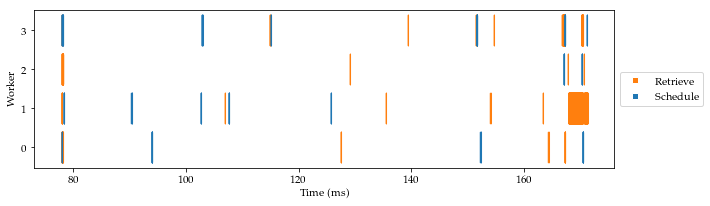

In [124]:
fig, ax = plt.subplots(figsize=(10, 3))
legend_elements = []

for t in sorted(wait_plot.Type.unique()):
    c = 'C0' if t == "Schedule" else 'C1'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    ax.scatter(x=wait_plot[wait_plot.Type == t]['Time (ms)'], 
               y=wait_plot[wait_plot.Type == t]['Idle'], 
               marker='$|$', 
               linewidth=0, 
               s=1000,
               color=c)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Worker")
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("../report/figures/idletime_4.pdf", format='pdf', bbox_inches='tight')
plt.show()

### 64 workers ###

In [114]:
files = os.listdir(GLOB_PATH)
forks = pd.concat([pd.read_csv(os.path.join(GLOB_PATH, f)) for f in files if f.startswith("S0") and f.endswith(".csv")])
joins = pd.concat([pd.read_csv(os.path.join(GLOB_PATH, f)) for f in files if f.startswith("S1") and f.endswith(".csv")])
forks = forks.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })
joins = joins.sort_values('time').rename(columns={
                'time': 'Time (ms)',
                'id': 'ID',
                'code': 'Code'
            })

display(forks.head(20))
display(joins.head(20))

,Time (ms),ID,Code,info1,info2
0,368.094,0,CREATE,0.0,0.0
0,368.530,1,CREATE,0.0,1.0
0,368.801,2,CREATE,0.0,2.0
0,369.110,3,CREATE,0.0,3.0
0,369.398,4,CREATE,0.0,4.0
0,369.712,5,CREATE,0.0,5.0
0,369.992,6,CREATE,0.0,6.0
0,370.270,7,CREATE,0.0,7.0
0,370.645,8,CREATE,0.0,8.0
0,370.972,9,CREATE,0.0,9.0


,Time (ms),ID,Code,info1,info2
0,387.263,0,CREATE,1.0,0.0
0,387.461,1,CREATE,1.0,1.0
0,387.662,2,CREATE,1.0,2.0
0,387.844,3,CREATE,1.0,3.0
0,388.026,4,CREATE,1.0,4.0
0,388.214,5,CREATE,1.0,5.0
0,388.394,6,CREATE,1.0,6.0
0,388.588,7,CREATE,1.0,7.0
0,388.792,8,CREATE,1.0,8.0
0,388.980,9,CREATE,1.0,9.0


In [115]:
n_ws = len(forks.ID.unique())
rt_wait = np.zeros((n_ws, len(forks)), dtype=bool)
sc_wait = np.zeros((n_ws, len(forks)), dtype=bool)

last_rt = np.zeros(n_ws, dtype=bool)
last_sc = np.zeros(n_ws, dtype=bool)

for i, (t, wid, code, i1, i2) in reversed(list(enumerate(forks.itertuples(index=False, name=None)))):
    if code == "SC_GLB":
        last_sc[wid] = True
    elif code == "RT_GLB":
        last_rt[wid] = True
    elif code == "SC_BGN":
        last_sc[wid] = False
    elif code == "RT_BGN":
        last_rt[wid] = False
    
    rt_wait[:, i] = last_rt
    sc_wait[:, i] = last_sc
    
rt_wait = np.logical_or(rt_wait, np.roll(rt_wait, 1, axis=1))
sc_wait = np.logical_or(sc_wait, np.roll(sc_wait, 1, axis=1))

In [116]:
dfs = []

for i in range(n_ws):
    rt = forks[['Time (ms)']].copy()
    rt['Idle'] = rt_wait[i, :]
    rt['Type'] = 'Retrieve'
    rt['Worker'] = i
    dfs.append(rt)
    
    sc = forks[['Time (ms)']].copy()
    sc['Idle'] = sc_wait[i, :]
    sc['Type'] = 'Schedule'
    sc['Worker'] = i
    dfs.append(sc)

wait = pd.concat(dfs).sort_values('Time (ms)')
wait.head()

,Time (ms),Idle,Type,Worker
0,368.094,False,Retrieve,0
0,368.094,False,Retrieve,2
0,368.094,False,Schedule,17
0,368.094,False,Retrieve,30
0,368.094,False,Schedule,30


In [117]:
wait_plot = wait.copy()

wait_plot.loc[:, 'Idle'] = wait.apply(lambda r: r['Worker'] if r['Idle'] else np.nan, axis=1)
wait_plot = wait_plot.dropna()

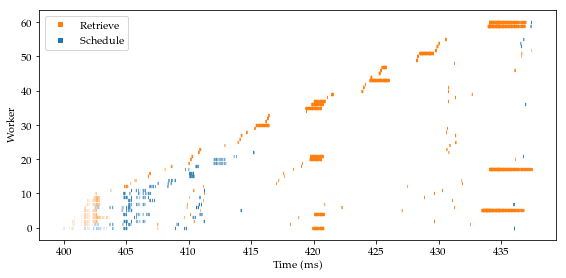

In [119]:
fig, ax = plt.subplots(figsize=(8, 4))
legend_elements = []

for t in sorted(wait_plot.Type.unique()):
    c = 'C0' if t == "Schedule" else 'C1'
    legend_elements.append(Line2D([0], [0], color='w', marker='s', markerfacecolor=c, label=t))
    
    ax.scatter(x=wait_plot[wait_plot.Type == t]['Time (ms)'], 
               y=wait_plot[wait_plot.Type == t]['Idle'], 
               marker='$|$', 
               linewidth=0, 
               s=10,
               color=c)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Worker")
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig("../report/figures/idletime_64.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Preformances ##

### Policy Comparison ###

In [93]:
dfs = []
files = [ f for f in os.listdir(POL_PATH) if f.endswith('.csv')]

for f in files:
    df = pd.read_csv(os.path.join(POL_PATH, f))
    df['Policy'] = os.path.splitext(f)[0]
    dfs.append(df)

sp = pd.concat(dfs)
sp.head()

,Workers,Time (ms),Policy
0,1,956503,Strong
1,1,948123,Strong
2,1,939916,Strong
3,1,940215,Strong
4,1,941942,Strong


In [94]:
avg = sp[sp.Workers == 1].groupby('Policy')['Time (ms)'].mean()

sp['Scalability'] = avg[sp.Policy].values / sp['Time (ms)'].values
sp.groupby(['Workers', 'Policy']).describe()

Scalability                                                    \
                      count      mean       std       min       25%       50%   
Workers Policy                                                                  
1       Relaxed         8.0  1.000058  0.008100  0.988533  0.991950  1.003960   
        Strict          8.0  1.000041  0.006817  0.987069  0.999010  1.002073   
        Strong          8.0  1.000030  0.005849  0.988949  0.997515  0.999945   
2       Relaxed         8.0  1.882196  0.017939  1.845575  1.879670  1.889930   
        Strict          8.0  1.882147  0.008917  1.862913  1.881910  1.885262   
        Strong          8.0  1.870485  0.012197  1.845057  1.869909  1.875826   
4       Relaxed         8.0  2.795213  0.198734  2.550440  2.628189  2.814713   
        Strict          8.0  3.028304  0.109108  2.900334  2.955045  2.990888   
        Strong          8.0  3.175389  0.130752  3.024807  3.054686  3.153654   
8       Relaxed         8.0  4.493200  0.254864  4.098004  4.350795  4.429201   
        Strict          8.0  5.002494  0.178399  4.813932  4.853371  4.937728   
        Strong          8.0  5.334425  0.190234  5.025250  5.175862  5.431095   
16      Relaxed         8.0  6.232064  0.238082  5.921980  6.027102  6.257321   
        Strict          8.0  6.680713  0.352731  6.324240  6.462798  6.656168   
        Strong          8.0  6.989987  0.331431  6.348032  6.873403  6.993623   
32      Relaxed         8.0  7.792668  0.331153  7.202836  7.573844  7.917955   
        Strict          8.0  7.600202  0.374902  7.237169  7.353358  7.505670   
        Strong          8.0  7.961273  0.504027  7.180410  7.688765  7.859974   
64      Relaxed         8.0  7.745803  0.483721  6.966833  7.558609  7.746094   
        Strict          8.0  7.964022  0.547708  6.972771  7.830104  7.887085   
        Strong          8.0  8.263098  0.498035  7.358711  8.081518  8.386901   
128     Relaxed         8.0  7.584886  0.247005  7.229103  7.454583  7.519768   
        Strict          8.0  7.477821  0.516264  6.626852  7.269437  7.536214   
        Strong          8.0  7.178338  0.464219  6.232920  7.122785  7.259483   
256     Relaxed         8.0  6.814506  0.211224  6.474525  6.696667  6.777863   
        Strict          8.0  6.316952  0.334581  5.908049  6.037884  6.261941   
        Strong          8.0  6.293493  0.365767  5.653267  6.084524  6.397269   

                                    Time (ms)                            \
                      75%       max     count        mean           std   
Workers Policy                                                            
1       Relaxed  1.006357  1.007941       8.0  957465.750   7780.801588   
        Strict   1.004011  1.006398       8.0  956022.750   6560.598051   
        Strong   1.004698  1.006402       8.0  945932.875   5552.506189   
2       Relaxed  1.894117  1.894891       8.0  508737.000   4905.056691   
        Strict   1.886687  1.890722       8.0  507952.750   2421.585475   
        Strong   1.877983  1.878618       8.0  505734.250   3325.753266   
4       Relaxed  2.911215  3.095279       8.0  344054.750  24423.521366   
        Strict   3.149523  3.158359       8.0  316052.125  11304.434104   
        Strong   3.300019  3.350890       8.0  298334.500  12198.053803   
8       Relaxed  4.719260  4.856387       8.0  213694.875  12159.741685   
        Strict   5.177027  5.267749       8.0  191319.250   6731.871524   
        Strong   5.468200  5.517477       8.0  177527.875   6467.357231   
16      Relaxed  6.389485  6.583281       8.0  153831.875   5879.464879   
        Strict   6.712441  7.477047       8.0  143428.250   7074.368962   
        Strong   7.186138  7.440732       8.0  135602.125   6645.925894   
32      Relaxed  8.043860  8.108344       8.0  123067.875   5391.117415   
        Strict   7.688916  8.338474       8.0  126045.750   5950.602172   
        Strong   8.296587  8.797739       8.0  119232.250   7517.244969   
64      Re

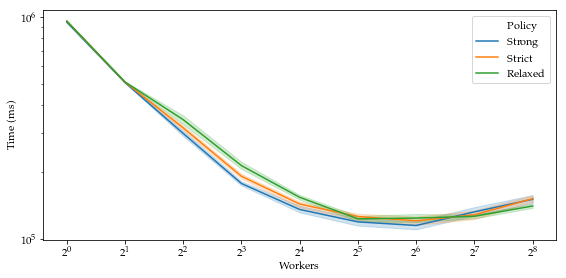

In [126]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data=sp, x='Workers', y='Time (ms)', hue='Policy', ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)

plt.tight_layout()
plt.savefig("../report/figures/time_policy.pdf", format='pdf', bbox_inches='tight')
plt.show()

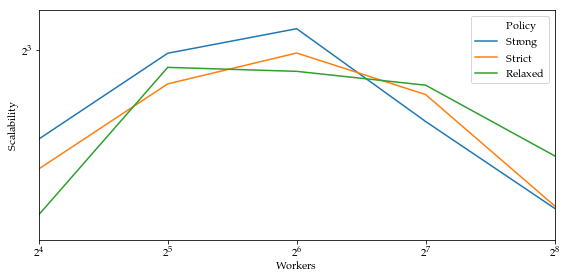

In [96]:
fig, ax = plt.subplots(figsize=(8, 4))

ideal = [i for i in range(sp.Workers.max())]
ax.set_alpha(0.1)

sns.lineplot(data=sp, x='Workers', y='Scalability', hue='Policy', ax=ax, ci=None)
ax.plot(ideal, ideal, ls='--', label='Ideal', c='gray')

ax.set_xlim((16, sp.Workers.max()))
ax.set_ylim((6, 8.5))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

plt.tight_layout()
plt.savefig("../report/figures/scalability_policy.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Framework Comparison ###

In [137]:
dfs = []
files = [ f for f in os.listdir(FW_PATH) if f.endswith('.csv')]

for f in files:
    df = pd.read_csv(os.path.join(FW_PATH, f))
    df['Framework'] = os.path.splitext(f)[0]
    dfs.append(df)

sf = pd.concat(dfs)
sf.head()

,Workers,Time (ms),Framework
0,1,27157986,DAC
1,1,26950801,DAC
2,1,26975706,DAC
3,1,26915843,DAC
4,1,26934187,DAC


In [138]:
avg = sf[sf.Workers == 1].groupby('Framework')['Time (ms)'].mean()

sf['Scalability'] = avg[sf.Framework].values / sf['Time (ms)'].values
sf.groupby(['Workers', 'Framework']).describe()

Scalability                                             \
                        count       mean       std        min        25%   
Workers Framework                                                          
1       DAC               5.0   1.000011  0.003621   0.993701   1.000415   
        FF                5.0   1.000003  0.001787   0.997918   0.998633   
        OMP               5.0   1.000006  0.002638   0.995558   0.999622   
        TBB               5.0   1.000004  0.002155   0.996156   1.000822   
2       DAC               5.0   1.918738  0.005025   1.909989   1.919508   
        FF                5.0   1.805363  0.027161   1.769173   1.792795   
        OMP               5.0   1.854138  0.001005   1.853086   1.853121   
        TBB               5.0   1.860542  0.001419   1.858637   1.860032   
4       DAC               5.0   3.428877  0.041197   3.392778   3.394476   
        FF                5.0   3.319048  0.021849   3.296511   3.300152   
        OMP               5.0   2.563408  0.194615   2.390966   2.409527   
        TBB               5.0   3.406083  0.002354   3.404297   3.404541   
8       DAC               5.0   5.876287  0.114123   5.732412   5.822390   
        FF                5.0   5.642327  0.016591   5.623338   5.632632   
        OMP               5.0   4.249816  0.294187   3.746134   4.254980   
        TBB               5.0   5.604504  0.211171   5.333066   5.438543   
16      DAC               5.0   8.873078  0.076904   8.750371   8.850588   
        FF                5.0   8.338293  0.080946   8.247684   8.270144   
        OMP               5.0   6.933669  0.814310   5.496464   7.131891   
        TBB               5.0   8.038698  0.255661   7.673309   7.926656   
32      DAC               5.0  11.812175  0.229574  11.565719  11.691297   
        FF                5.0   9.459931  0.116596   9.360747   9.382643   
        OMP               5.0   8.410820  0.424154   7.956696   8.285543   
        TBB               5.0  10.502078  0.283973  10.075431  10.431863   
64      DAC               5.0  14.076305  0.150060  13.929609  13.953239   
        FF                5.0   7.771621  0.108602   7.581758   7.783508   
        OMP               5.0   9.215330  0.562362   8.514568   8.797594   
        TBB               5.0  11.695784  0.554435  10.938106  11.331738   
128     DAC               5.0  14.708052  0.249848  14.270744  14.736466   
        FF                5.0   4.464362  0.098671   4.352571   4.398024   
        OMP               5.0   6.547085  1.385429   4.534048   5.661846   
        TBB               5.0  11.039357  2.013653   8.840319   8.987209   
256     DAC               5.0   6.838309  1.638933   5.217015   5.360126   
        FF                5.0   0.906468  0.602261   0.310402   0.403243   
        OMP               5.0   3.678889  0.319547   3.384127   3.474080   
        TBB               5.0   6.500065  2.218254   3.989012   4.170727   

                                                   Time (ms)              \
                         50%        75%        max     count        mean   
Workers Framework                                                          
1       DAC         1.001340   1.001957   1.002640       5.0  26986904.6   
        FF          0.999941   1.001331   1.002191       5.0  26224460.0   
        OMP         1.001446   1.001509   1.001893       5.0  25698116.0   
        TBB         1.000921   1.000924   1.001196       5.0  25627916.4   
2       DAC         1.920322   1.921258   1.922611       5.0  14065004.6   
        FF          1.808386   1.813596   1.842863       5.0  14528498.0   
        OMP         1.854529   1.854569   1.855386       5.0  13859873.2   
        TBB         1.860247   1.861450   1.862345       5.0  13774442.4   
4       DAC         3.410542   3.470127   3.476464       5.0   7871384.2   
        FF          3.315896   3.336830   3.345852       5.0   7901472.2   
        OMP         2.468079   2.767126   2.781343       5.0  100

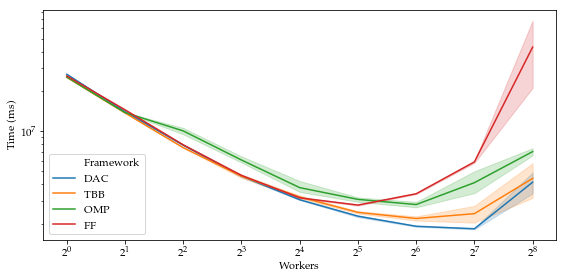

In [139]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data=sf, x='Workers', y='Time (ms)', hue='Framework', ax=ax)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)

plt.tight_layout()
plt.savefig("../report/figures/time_framework.pdf", format='pdf', bbox_inches='tight')
plt.show()

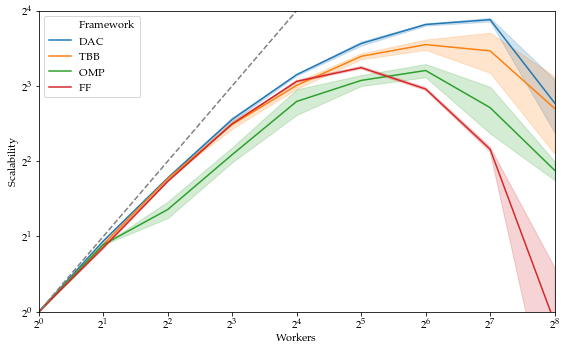

In [142]:
fig, ax = plt.subplots(figsize=(8, 5))

ideal = [i for i in range(sf.Workers.max())]

sns.lineplot(data=sf, x='Workers', y='Scalability', hue='Framework', ax=ax, ci='sd')
ax.plot(ideal, ideal, ls='--', label='Ideal', c='gray')

ax.set_xlim((1, sf.Workers.max()))
ax.set_ylim((1, 16))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

plt.tight_layout()
plt.savefig("../report/figures/scalability_framework.pdf", format='pdf', bbox_inches='tight')
plt.show()